In [1]:
include("../ToolBox/ToolBox.jl")
import FileIO
using .ToolBox
using .Geometry
using .Load
using Colors
import JLD

In [2]:
master_folder = "S1A_IW_SLC__1SDV_20170321T054035_20170321T054103_015786_019FEE_8439.SAFE"
split(split(master_folder, "_")[end], ".")[1]

"8439"

In [16]:
if master_folder != 0
    if typeof(master_folder) != String
        print("hey")
    end
end


In [ ]:
# TODO
# 1) skær interferogram assembly ind til benet
#     - skal kunne lave complex coherence for to safe og gemme relevante til
# TEST

# 2) wrap S1A loop rundt om, struktur:
# for safe in safe_files:
#   check if sequential or single
#   if sequential:
#       update master in each iteration
#       check if safe pair is overmaster slave
#            compute interfergram_assembly
#            continue
#       else
#            compute interfergram_assembly
#            resample to overmaster geometry with coregister_slave

#   elseif single master
#       dont update master, just iterate through slaves
#       compute interfergram_assembly
# TEST

# 3) Skriv docstrings

In [2]:
#lat_lon = hcat([8.17108154296875, 56.38350163536175],
#               [8.5638427734375, 56.38350163536175],
#               [8.5638427734375, 56.615442833370906],
#               [8.17108154296875, 56.615442833370906])
#reflector_index = to_line_sample(lat_lon, heights, precise_orbit...,meta)

2×4 Array{Float64,2}:
  8.17108   8.56384   8.56384   8.17108
 56.3835   56.3835   56.6154   56.6154 

In [77]:
# product_folders has to be [master, slave]
function interferogram_assembly(product_folders, master_view, dem_path, subswath, polarization, result_folder, dem_nan, pod_folder, kernel = ones(4,14), keep_intensity = false)
    
    n_coherence = length(product_folders)-1
    dem = 0
    lut1 = 0
    lut2 = 0
    lut_status = Array{Bool, 1}(undef, length(product_folders)-1)
    lut_status .= false
    precise_orbit = 0
    master_data = 0
    lines = 0
    samples = 0
    
    stride_line = floor(Int,size(kernel)[1]/2)
    stride_sample = floor(Int,size(kernel)[2]/2)
    
    # Save folder names
    path = joinpath(result_folder,"product_folders.txt")
    open(path, "w") do io
        for folder in product_folders
            write(io, folder * "\n")
        end
    end;
    
    # get pod paths
    pod_paths = [Load.pod_path(folder, pod_folder) for folder in product_folders]
    
    # get paths
    file_paths = [Load.slc_paths(folder, polarization, subswath) for folder in product_folders]
    meta = [Load.slc_meta(path[2]) for path in file_paths]
    calibration = [Load.slc_calibration(file_paths[i][3],meta[i]["t_0"]) 
                                for i in 1:length(product_folders)];
    # load pod
    if precise_orbit == 0
        println("load POD")
        precise_orbit = [Load.precise_orbit(pod_paths[i],meta[i]["t_0"]) 
                                for i in 1:length(product_folders)]
    end
    @assert precise_orbit == 0 return precise_orbit

    # load DEM
    if dem == 0
        # load DEM
        footprint = SlcUtil.footprint(meta[2], master_view)
        latlon_window = ((minimum(footprint[1]), maximum(footprint[1])), (minimum(footprint[2]), maximum(footprint[2])))
        dem = Load.dem(dem_path, latlon_window; nan_fill = dem_nan, padding=[90,90]);
    end

    for i in 1:n_coherence
        println("i: ",i)
        if i == 1
            lut = lut1
            index = [1,2]
        else
            lut = lut2
            index = [1,3]
        end

        # coreg_slave data
        if !(lut_status[i])
            println("coreg no lut")
            slave_data,flat,lut =  coregister_slave(master_view,file_paths[index[2]][1],
                                                    meta[index],precise_orbit[index],dem)
            @assert slave_data == 0 return meta
            # save lut
            if i==1
                lut1 = lut
            else
                lut2 = lut
            end
            lut_status[i] = true
            lut_path = joinpath(result_folder,string(index[1])*string(index[2])*"_lut.jld")
            JLD.save(lut_path, "data", lut)

        else
            println("coreg with lut")
            slave_data,flat =  coregister_slave(master_view,file_paths[index[2]][1],
                                                    meta[index],precise_orbit[index],dem,lut)
        end

        slave_data, mosaic_view = SlcUtil.mosaic(slave_data,master_view,meta[index[1]]);
        flat, mosaic_view = SlcUtil.mosaic(flat,master_view,meta[index[1]]);
        slave_data = SlcUtil.calibrate_slave_data(slave_data, mosaic_view,lut1, calibration[index[2]]);

        if i == 1
        # Get master data
            master_data = Load.slc_data(file_paths[index[1]][1],master_view);
            master_data,mosaic_view = SlcUtil.mosaic(master_data,master_view,meta[index[1]]);
            master_data = SlcUtil.calibrate_data(master_data, Misc.flatten(mosaic_view...)..., calibration[index[1]]);
        end

        # Compute coherence
        complex_coherence, master_intensity, slave_intensity, lines, samples = SlcUtil.complex_coherence(
                                                            master_data, slave_data, flat, kernel, mosaic_view);

        slave_data = 0

        # subsample 
        complex_coherence = complex_coherence[1:stride_line:end,1:stride_sample:end]

        # save 
        date_string_master = split(split(product_folders[1], "_")[6], "T")[1]  # 6th entry is date, and we throw away time
        date_string_slave = split(split(product_folders[1], "_")[6], "T")[end]  # 6th entry is date, and we throw away time
        coherence_path = joinpath(result_folder, date_string_master*"_"*date_string_slave*"_"*polarization*"_coher.jld")
        println("Save")
        JLD.save(coherence_path, "data", complex_coherence)
        
        phase_img = SlcUtil.plot_phase(complex_coherence)
        FileIO.save("Coherence_run1_1.jpg",phase_img)
        
        if keep_intensity
            println("Saving intensities")
            slave_intensity = slave_intensity[1:stride_line:end,1:stride_sample:end]
            slave_path = joinpath(result_folder,string(index[2])*polarization*"_itens.jld")
            master_path = joinpath(result_folder,string(index[1])*polarization*"_itens.jld")
            JLD.save(slave_path, "data", slave_intensity)
            if i == 1
                println("Save master intens")
                master_intensity = master_intensity[1:stride_line:end,1:stride_sample:end]
                JLD.save(master_path, "data", master_intensity)
            end
        end
        
        phase_img = 0;
        complex_coherence = 0;
    end
    
    println("Save AUX info")
    lines = lines[1:stride_line:end]
    samples = samples[1:stride_sample:end]
    
    # save lines and samples 
    line_sample_path = joinpath(result_folder,"line_sample.jld")
    JLD.save(line_sample_path, "lines", lines, "samples", samples)
    
    # Save heights
    heights = Misc.interp_grid(lut1["master_line"] ,lut1["master_sample"],
        reshape(lut1["heights"],(length(lut1["master_line"]),length(lut1["master_sample"])))
        ,lines, samples);
    
    heights_path = joinpath(result_folder,"heights.jld")
    JLD.save(heights_path, "data", heights)
    
    return 1
    
end

interferogram_assembly (generic function with 3 methods)

In [78]:
master_folder = "/home/data/eigil/frame407_406/S1A_IW_SLC__1SDV_20170321T054035_20170321T054103_015786_019FEE_8439.SAFE"
slave1_folder = "/home/data/eigil/frame407_406/S1A_IW_SLC__1SDV_20170402T054035_20170402T054103_015961_01A51D_080F.SAFE"
slave2_folder = "/home/data/eigil/frame407_406/S1A_IW_SLC__1SDV_20170309T054035_20170309T054103_015611_019AB8_A0F2.SAFE"
product_folders = [master_folder, slave1_folder];
result_folder = "/home/data/eigil/results/interferogram"
dem_path = "/home/data/eigil/srtm_38_01_reprojected.tif"

dem_nan = 40

master_view = [2000-1524:6000-1524, 4801:7801]

2-element Array{UnitRange{Int64},1}:
 476:4476 
 4801:7801

In [79]:
POD = interferogram_assembly(product_folders, master_view, dem_path, 3, "VV", result_folder, dem_nan, "/home/data/eigil/S1A_POEORB")

load POD


2-element Array{Tuple{Array{Float64,2},Array{Float64,1}},1}:
 ([-1.344267338658e6 1.191507931518e6 … 7236.957383 -1578.311854; -1.360392352316e6 1.263821270826e6 … 7225.569319 -1655.266302; … ; -2.041613600784e6 -5.85701926109e6 … 3919.759592 6494.014084; -2.045494737848e6 -5.817491142448e6 … 3985.78314 6455.270668], [-24018.0, -24008.0, -23998.0, -23988.0, -23978.0, -23968.0, -23958.0, -23948.0, -23938.0, -23928.0  …  69492.0, 69502.0, 69512.0, 69522.0, 69532.0, 69542.0, 69552.0, 69562.0, 69572.0, 69582.0])
 ([-1.343599622472e6 1.188747941206e6 … 7237.401238 -1575.362168; -1.359734073403e6 1.261065879764e6 … 7226.04533 -1652.323944; … ; -2.041491643524e6 -5.858757061826e6 … 3916.803715 6495.7311; -2.045385218737e6 -5.819258394568e6 … 3982.84881 6457.020496], [-24018.0, -24008.0, -23998.0, -23988.0, -23978.0, -23968.0, -23958.0, -23948.0, -23938.0, -23928.0  …  69492.0, 69502.0, 69512.0, 69522.0, 69532.0, 69542.0, 69552.0, 69562.0, 69572.0, 69582.0])  

In [82]:
path[1][1]

"/home/data/eigil/frame407_406/S1A_IW_SLC__1SDV_20170321T054035_20170321T054103_015786_019FEE_8439.SAFE/measurement/s1a-iw3-slc-vv-20170321t054035-20170321t054103-015786-019fee-006.tiff"

In [76]:
meta

2-element Array{Dict{String,Any},1}:
 Dict("image_number" => "006","number_of_samples" => 25540,"mode" => "IW","mission_data_id" => "106478","burst_meta" => Dict{String,Any}("data_dc_t0" => [0.005361470572828085, 0.005361470572828085, 0.005360031904928674, 0.005360031904928674, 0.005360031904928674, 0.005360031904928674, 0.005360031904928674, 0.005360031904928674, 0.005360031904928674, 0.005360031904928674],"data_dc_polynomial" => [26.531 -56235.86 5.670795e7; 32.83048 -78993.45 7.740382e7; … ; 10.79259 35291.87 -2.020984e7; 18.68135 -3219.784 1.232137e7],"dc_estimate_list" => Any[OrderedCollections.OrderedDict{Any,Any}("azimuthTime" => "2017-03-21T05:40:36.074762","t0" => "5.361470572828085e-03","geometryDcPolynomial" => OrderedCollections.OrderedDict{Any,Any}(:count => "3","" => "1.377728e+00 -3.925858e+02 7.779389e+04"),"dataDcPolynomial" => OrderedCollections.OrderedDict{Any,Any}(:count => "3","" => "2.653100e+01 -5.623586e+04 5.670795e+07"),"dataDcRmsError" => "7.239415168762207e+

In [31]:
## Iterates through AA or BB
count = 0
dir_master = 0
master_folder = "/home/data/eigil/S1A_IW_SLC__1SDV_20170309T054035_20170309T054103_015611_019AB8_A0F2.SAFE"
for (root, dirs, files) in walkdir("/home/data/eigil/frame407_406")
    for dir in dirs
        if split(dir, ".")[end] == "SAFE"
            if string(split(split(dir, "/")[end], "_")[1][end]) == "A"
                if count == 0
                    dir_master = dir
                else
                    acq_date_slave = extract_datetime(dir)
                    acq_date_master = extract_datetime(dir_master)
                    days_between = days_between_acquisitions(acq_date_slave, acq_date_master)
                    println("days between \n", dir_master, "\n", dir)
                    println("is: ", days_between, "\n")
                    dir_master = dir
                end

                
                #interferogram_assembly(product_folders, master_view, dem_path, 3, "VV", result_folder, dem_nan, "/home/data/eigil/S1A_POEORB")
                #master_folder = joinpath(root, dir)
                count += 1
            end
        end
    end
end
count

UndefVarError: UndefVarError: extract_datetime not defined

In [163]:
# S1A loop
S1A = all_files[hcat(split.(all_files, "_")...)[1, :] .== "S1A"]
master_path = 0
for i in range(2, stop=length(S1A))
    # sequential
    if i == 2
        master_path = S1A[i-1]
    end
    slave_path = S1A[i]
    
    @assert Date(extract_datetime(master_path))<Date(extract_datetime(slave_path)) "Acquisition time of master is 
    after slave. \nMaster: $(master_path) \nSlave:  $(slave_path)"
    # måske tjek 12 dage eller 6 dage også
    
    # interferogram her
    master_path = slave_path
end

S1A_IW_SLC__1SDV_20170309T054035_20170309T054103_015611_019AB8_A0F2.SAFE
S1A_IW_SLC__1SDV_20170321T054035_20170321T054103_015786_019FEE_8439.SAFE

S1A_IW_SLC__1SDV_20170321T054035_20170321T054103_015786_019FEE_8439.SAFE
S1A_IW_SLC__1SDV_20170402T054035_20170402T054103_015961_01A51D_080F.SAFE

S1A_IW_SLC__1SDV_20170402T054035_20170402T054103_015961_01A51D_080F.SAFE
S1A_IW_SLC__1SDV_20170414T054036_20170414T054104_016136_01AA6F_57BD.SAFE

S1A_IW_SLC__1SDV_20170414T054036_20170414T054104_016136_01AA6F_57BD.SAFE
S1A_IW_SLC__1SDV_20170426T054036_20170426T054104_016311_01AFCB_FE90.SAFE

S1A_IW_SLC__1SDV_20170426T054036_20170426T054104_016311_01AFCB_FE90.SAFE
S1A_IW_SLC__1SDV_20170508T054037_20170508T054105_016486_01B519_75D9.SAFE

S1A_IW_SLC__1SDV_20170508T054037_20170508T054105_016486_01B519_75D9.SAFE
S1A_IW_SLC__1SDV_20170520T054038_20170520T054106_016661_01BA73_C797.SAFE

S1A_IW_SLC__1SDV_20170520T054038_20170520T054106_016661_01BA73_C797.SAFE
S1A_IW_SLC__1SDV_20170601T054033_20170601T054

In [161]:
master_path = "S1A_IW_SLC__1SDV_20170309T054035_20170309T054103_015611_019AB8_A0F2.SAFE"
slave_path = "S1A_IW_SLC__1SDV_20170309T054035_20170309T054103_015611_019AB8_A0F2.SAFE"


AssertionError: AssertionError: Acquisition time of master is 
after slave. 
Master: S1A_IW_SLC__1SDV_20170309T054035_20170309T054103_015611_019AB8_A0F2.SAFE, 
Slave:  S1A_IW_SLC__1SDV_20170309T054035_20170309T054103_015611_019AB8_A0F2.SAFE

In [104]:
all_files = all_SAFE_files(directory)
sorted_files = all_files[sortperm(extract_datetime.(all_files))]
#for loop med interferogram

30-element Array{String,1}:
 "S1B_IW_SLC__1SDV_20170303T053950_20170303T054018_004540_007E86_420F.SAFE"
 "S1A_IW_SLC__1SDV_20170309T054035_20170309T054103_015611_019AB8_A0F2.SAFE"
 "S1B_IW_SLC__1SDV_20170315T053950_20170315T054018_004715_0083B0_7EE9.SAFE"
 "S1A_IW_SLC__1SDV_20170321T054035_20170321T054103_015786_019FEE_8439.SAFE"
 "S1B_IW_SLC__1SDV_20170327T053950_20170327T054018_004890_0088AE_3CC1.SAFE"
 "S1A_IW_SLC__1SDV_20170402T054035_20170402T054103_015961_01A51D_080F.SAFE"
 "S1B_IW_SLC__1SDV_20170408T053951_20170408T054019_005065_008DBC_AEEF.SAFE"
 "S1A_IW_SLC__1SDV_20170414T054036_20170414T054104_016136_01AA6F_57BD.SAFE"
 "S1B_IW_SLC__1SDV_20170420T053952_20170420T054019_005240_0092C6_3820.SAFE"
 "S1A_IW_SLC__1SDV_20170426T054036_20170426T054104_016311_01AFCB_FE90.SAFE"
 "S1B_IW_SLC__1SDV_20170502T053952_20170502T054020_005415_0097DA_AB1F.SAFE"
 "S1A_IW_SLC__1SDV_20170508T054037_20170508T054105_016486_01B519_75D9.SAFE"
 "S1B_IW_SLC__1SDV_20170514T053953_20170514T054021_005590_00

In [84]:
## Iterates through AA or BB
count = 0
dir_master = 0
all_files = Array{String, 1}(undef, length(product_folders)-1)

master_folder = "/home/data/eigil/S1A_IW_SLC__1SDV_20170309T054035_20170309T054103_015611_019AB8_A0F2.SAFE"
number_of_SAFE_files("/home/data/eigil/frame407_406")

30

In [87]:
using Dates
# SAFE_path can be path or SAFE file name, works either way.
function extract_datetime(SAFE_path, start_date=true)
    extract_SAFE_name = split(SAFE_path, "/")[end]
    if start_date
        date_string = split(extract_SAFE_name, "_")[6]
    else
        date_string = split(extract_SAFE_name, "_")[7]
    end
    year = date_string[1:4]
    month = date_string[5:6]
    day = date_string[7:8]
    hour = date_string[10:11]
    minute = date_string[12:13]
    second = date_string[14:end]
    date_int = parse.(Int, [year, month, day, hour, minute, second])
    return DateTime(date_int...)
end

function days_between_acquisitions(date1, date2)
    return abs(Date(date1) - Date(date2))
end

# counts total number of SAFE files in directory
function number_of_SAFE_files(directory)
    count = 0
    for (root, dirs, files) in walkdir(directory)
        for dir in dirs
            if split(dir, ".")[end] == "SAFE"
                count += 1
            end
        end
    end
    return count
end

# returns all SAFE file names in directory as array
function all_SAFE_files(directory)
    all_files = Array{String, 1}(undef, number_of_SAFE_files(directory))
    for (root, dirs, files) in walkdir(directory)
        for dir in dirs
            if split(dir, ".")[end] == "SAFE"
                all_files[count + 1] = dir
                count += 1
            end
        end
    end
    return all_files
end

all_SAFE_files (generic function with 1 method)

In [68]:
date1 = extract_date("S1A_IW_SLC__1SDV_20170309T054035_20170309T054103_015611_019AB8_A0F2.SAFE")
date2 = extract_date("S1A_IW_SLC__1SDV_20170321T054035_20170321T054103_015786_019FEE_8439.SAFE")
max(date1, date2)

days between 
S1A_IW_SLC__1SDV_20170309T054035_20170309T054103_015611_019AB8_A0F2.SAFE
S1A_IW_SLC__1SDV_20170309T054035_20170309T054103_015611_019AB8_A0F2.SAFE


In [57]:
date2 = extract_date("S1A_IW_SLC__1SDV_20170309T054010_20170309T054037_015611_019AB8_1BA8.SAFE")
if Date(date1) == Date(date2)
    select_date = max(date1, date2)
end
select_date

2017-03-09T05:40:35

In [39]:
tmp = split("S1A_IW_SLC__1SDV_20170309T054035_20170309T054103_015611_019AB8_A0F2.SAFE", "/")[end]
split(tmp, "_")[6]

"S1A_IW_SLC__1SDV_20170309T054035_20170309T054103_015611_019AB8_A0F2.SAFE"

In [ ]:
# for later when there is one master
count = 0
for (root, dirs, files) in walkdir("/home/data/eigil")
    for dir in dirs
        if split(dir, ".")[end] == "SAFE"
            if joinpath(root, dir) == master_folder
                continue
            else
                product_folders[master_folder, joinpath(root, dir)]
                interferogram_assembly(product_folders, master_view, dem_path, 3, "VV", result_folder, dem_nan, "/home/data/eigil/S1A_POEORB")
            count += 1
        end
    end
end
print(count)

In [15]:
#coherence1 = JLD.load(joinpath(folder, "12VV_coher.jld"), "data")[:,end:-1:1]
coherence1 = JLD.load("/home/data/eigil/results/interferogram/12VV_coher.jld", "data")[:, end:-1:1];

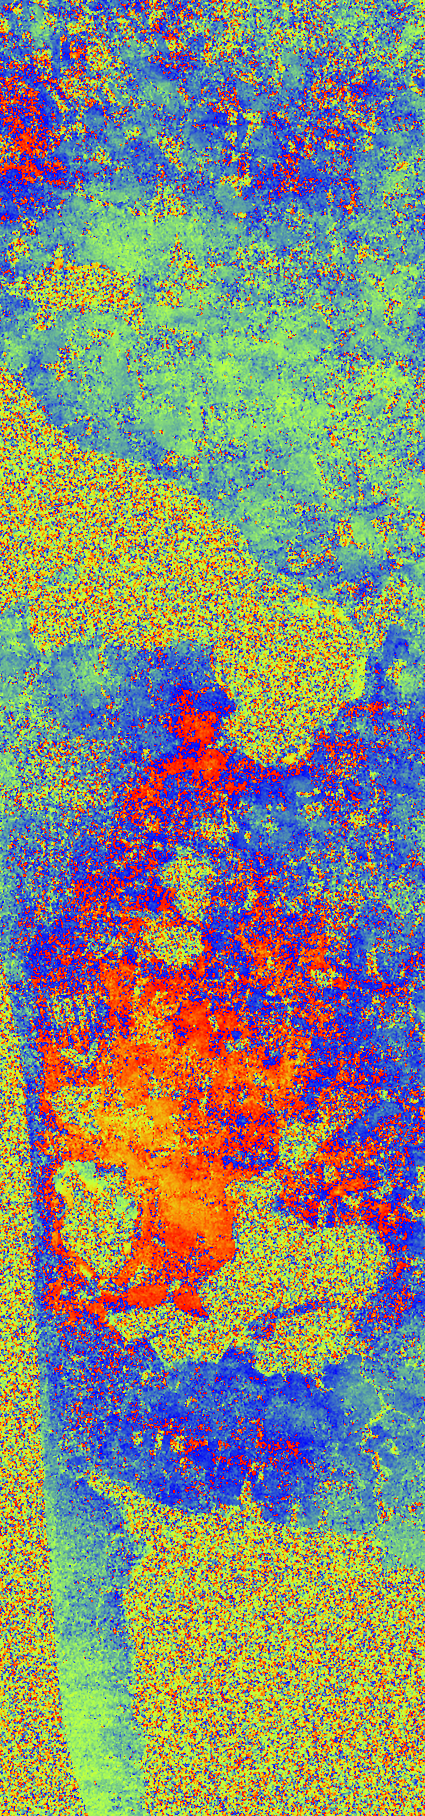

In [56]:
coherence1 = JLD.load("/home/data/eigil/results/interferogram/12VV_coher.jld", "data")[:, end:-1:1];
phase_img = SlcUtil.plot_phase(coherence1)
#FileIO.save("Coherence_run1_1.jpg",phase_img)